In [34]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import seaborn as sns # This time sns for plotting the confusion matrix

### Preprocessing data

In [2]:
data_c = pd.read_parquet('./Local/2017_Clean/Combined.parquet')
data_f1 = pd.read_parquet('./Local/2017_Final/Combined_1.parquet')
data_f2 = pd.read_parquet('./Local/2017_Final/Combined_2.parquet')

datasets = {'Clean data': data_c, 'Final data 1': data_f1, 'Final data 2': data_f2}
matrices = {}
roc_data = {}

print(data_f2['Label'].value_counts())

Label
BENIGN                        4293798
DoS Hulk                       345692
DDoS                           256028
PortScan                       181388
DoS GoldenEye                   20572
FTP-Patator                     11862
DoS slowloris                   10770
DoS Slowhttptest                10456
SSH-Patator                      6438
Bot                              3896
Web Attack � Brute Force         2940
Web Attack � XSS                 1304
Infiltration                       72
Web Attack � Sql Injection         42
Heartbleed                         22
Name: count, dtype: int64


### Isolation Forest function

In [39]:
def IsoForest(data):

    if 'Label' in data.columns:
        labels = data['Label']
        data = data.drop(columns=['Label'])
    elif ' Label' in data.columns:
        labels = data[' Label']
        data = data.drop(columns=[' Label'])
    else:
        raise ValueError("DataFrame does not contain a label column")
    
    labels = np.where(labels == 'BENIGN', 0, 1)
    data = data.select_dtypes(include=[np.number]).fillna(0)

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    iso_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.3, max_features=1.0, random_state=42)
    iso_forest.fit(data_scaled)

    predictions = iso_forest.predict(data_scaled)
    # Predictions: 1 for normal (BENIGN), -1 for anomaly (ATTACK)
    predictions = np.where(predictions == 1, 0, 1)

    accuracy = metrics.accuracy_score(labels, predictions)
    print(f"Accuracy: {accuracy}")

    print(metrics.classification_report(labels, predictions, zero_division=1))

    conf_matrix = metrics.confusion_matrix(labels, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    fpr, tpr, _ = metrics.roc_curve(labels, predictions)
    roc_auc = metrics.roc_auc_score(labels, predictions)
    print(f"ROC AUC Score: {roc_auc}")

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

### Running the function for different datasets

Accuracy: 0.7367307512905031
              precision    recall  f1-score   support

           0       0.91      0.76      0.83   2146899
           1       0.34      0.61      0.43    425741

    accuracy                           0.74   2572640
   macro avg       0.62      0.69      0.63   2572640
weighted avg       0.81      0.74      0.76   2572640



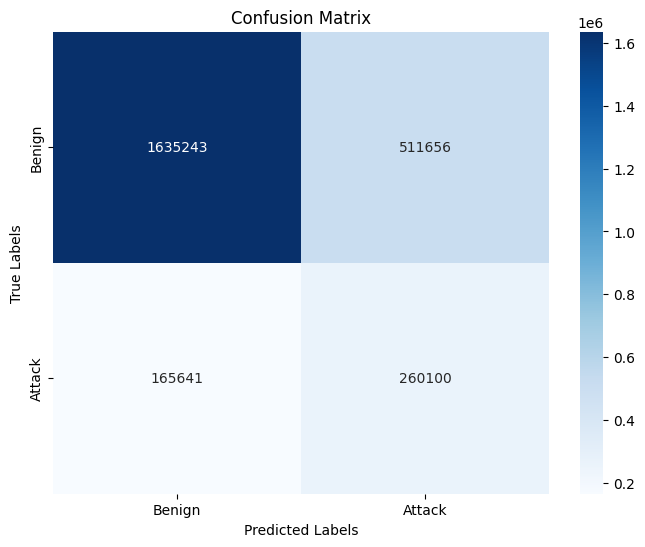

ROC AUC Score: 0.6863057712691023


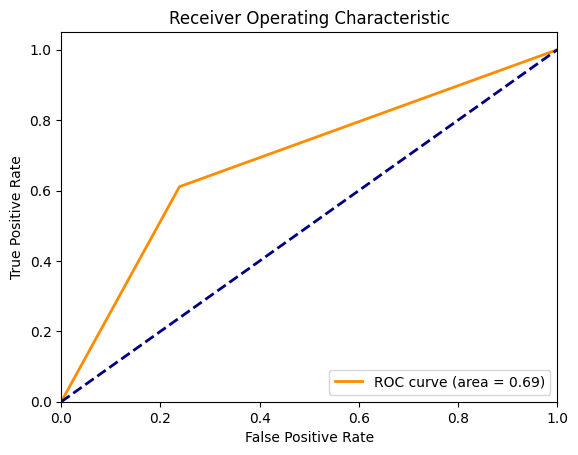

In [40]:
IsoForest(data_c)

Accuracy: 0.7316099415386529
              precision    recall  f1-score   support

           0       0.90      0.76      0.83   4293798
           1       0.33      0.59      0.42    851482

    accuracy                           0.73   5145280
   macro avg       0.62      0.68      0.62   5145280
weighted avg       0.81      0.73      0.76   5145280



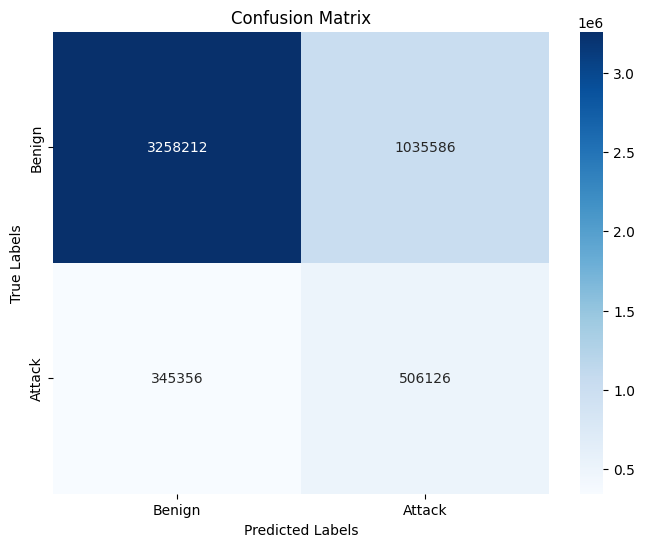

ROC AUC Score: 0.6766120862129301


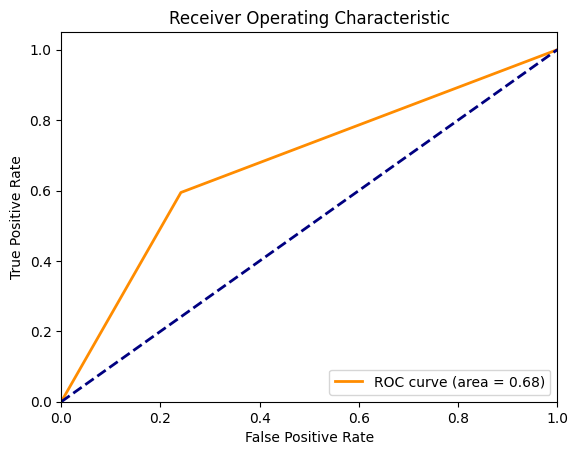

In [41]:
IsoForest(data_f1)

Accuracy: 0.7297764164438086
              precision    recall  f1-score   support

           0       0.90      0.76      0.82   4293798
           1       0.33      0.59      0.42    851482

    accuracy                           0.73   5145280
   macro avg       0.61      0.67      0.62   5145280
weighted avg       0.81      0.73      0.76   5145280



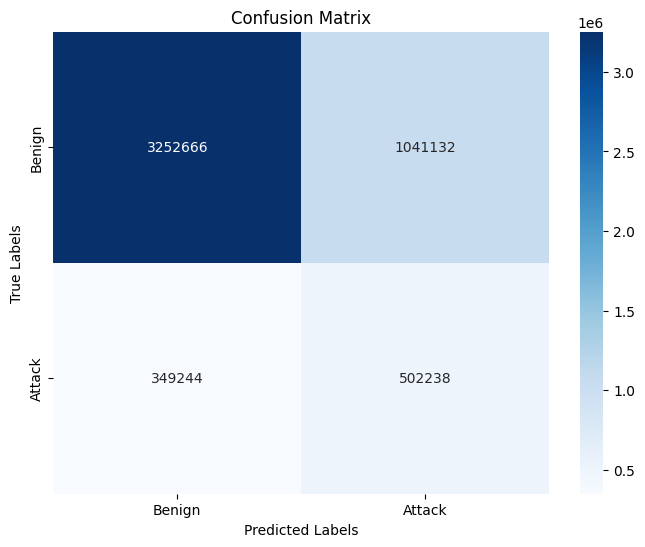

ROC AUC Score: 0.673683192806699


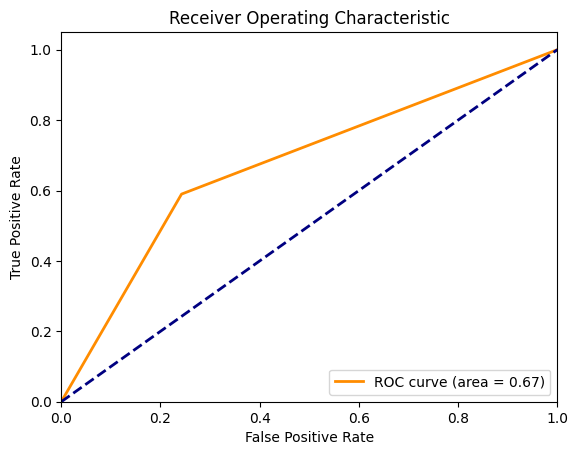

In [42]:
IsoForest(data_f2)